In [1]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
import PIL
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import pandas as pd
import seaborn as sns

import os
from tqdm import tqdm

from ultralytics.utils import ops
from ultralytics.utils.plotting import save_one_box

from net.os_net import osnet_ibn_x1_0
import torch.nn.functional as F
from net.os_net import OSNet
from net.resnet import Resnet50
from net.os_net import get_embedding_model, osnet_ibn_x1_0, OSNet, OSBlock
from dataset.utils import make_transform
from torchvision import transforms
import torch
from torch import nn

from dataset.utils import make_transform

In [24]:
# Load a model
model = YOLO('yolov8n.pt')  # pretrained YOLOv8n model

In [25]:
results = model('../../data/person_reid/Pier Park Panama City Hour of Watching People Walk By.mp4', stream=True, verbose=False)

In [4]:
for i in range(600):
    next(results)

/home/nevin/anaconda3/envs/cv/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


In [26]:
img_list = []
for i in range(300):
    r = next(results)
    if i %5 == 0:
        print(f"Frame: {i}/300", sep='\r', end='\r')
        # plt.imshow(r.orig_img)
        # plt.show()
        # plt.clf()
        for class_label, xyxy in zip(r.boxes.cls, r.boxes.xyxy):
            if class_label == 0:
                im_crop = save_one_box(xyxy, r.orig_img, save=False)
                # plt.imshow(im_crop)
                img_list.append(PIL.Image.fromarray(im_crop))
                # plt.show()
                # plt.clf()

### Dataloader for imglist

In [27]:
class ImageListDataset(torch.utils.data.Dataset):
    def __init__(self, image_list, transform=None):
        self.image_list = image_list
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image = self.image_list[index]

        if isinstance(image, PIL.Image.Image):
            img = image
        else:
            img = PIL.Image.open(image)

        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, index

In [28]:
dataset = ImageListDataset(img_list, transform = make_transform(is_train = False, is_inception = False))

In [29]:
dl = torch.utils.data.DataLoader(
        dataset,
        batch_size = 16,
        shuffle = False,
        num_workers = 4,
        pin_memory = True
)

### Embedding values

In [48]:
model_name = 'resnet'

In [49]:
if model_name == 'resnet':
    model = Resnet50(embedding_size=512, pretrained=True, is_norm=1, bn_freeze =1).cuda()
elif model_name == 'osnet':
    model = osnet_ibn_x1_0(pretrained=True).cuda()

/home/nevin/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/nevin/anaconda3/envs/cv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
model.load_state_dict(torch.load('models/resnet50_best.pth')['model_state_dict'])

<All keys matched successfully>

In [51]:
embeddings, indices = [], []
model.eval()
iterator = tqdm(enumerate(dl))
for i, dat in iterator:
    imgs, inds = dat
    imgs = imgs.cuda()
    res = model(imgs)
    embeddings.append(res.cpu().detach().numpy())
    indices.append(inds.cpu().numpy())

23it [00:00, 27.31it/s]


In [52]:
indices, embeddings = np.concatenate(indices), np.concatenate(embeddings)

### Dimensionality reduction

In [53]:
tsne = TSNE(n_components=2, random_state=0)  # Specify the desired output dimension
reduced_data = tsne.fit_transform(embeddings)

In [54]:
reduced_df = pd.DataFrame(reduced_data, columns=['x1', 'x2'])
reduced_df['y'] = indices

<Axes: xlabel='x1', ylabel='x2'>

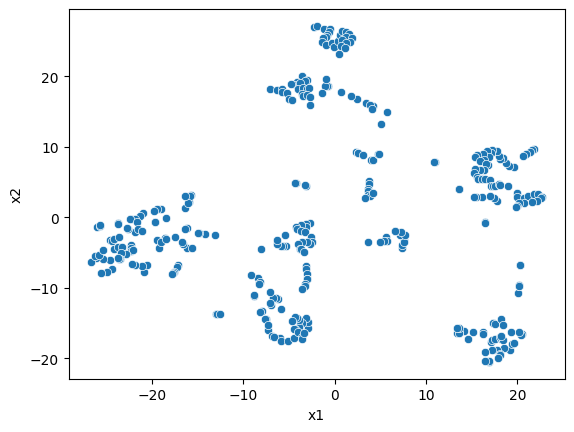

In [55]:
sns.scatterplot(x=reduced_df['x1'], y=reduced_df['x2'])

### Clustering

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(embeddings)

In [57]:
num_clusters = 13

In [58]:
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='complete')
cluster_labels = agg_clustering.fit_predict(X_scaled)

In [59]:
reduced_df['cluster'] = cluster_labels

<Axes: xlabel='x1', ylabel='x2'>

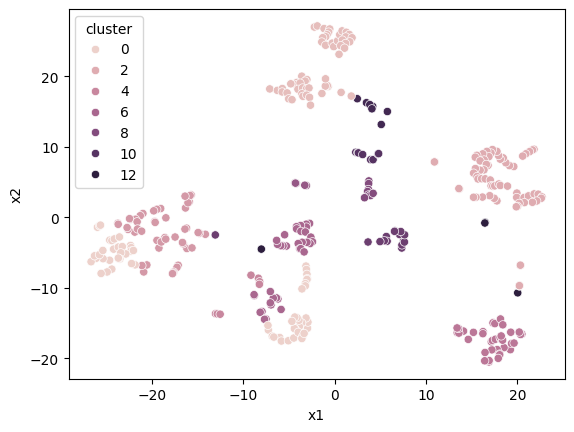

In [60]:
sns.scatterplot(x=reduced_df['x1'], y=reduced_df['x2'], hue=reduced_df['cluster'])

In [61]:
results_folder = f'{model_name}_clustering'
if not os.path.exists(os.path.join('results', results_folder)):
    os.mkdir(os.path.join('results', results_folder))
    
for cluster in range(num_clusters):
    cluster_folder = str(cluster)
    if not os.path.exists(os.path.join('results', results_folder, cluster_folder)):
        os.mkdir(os.path.join('results', results_folder, cluster_folder))
        
    indices = reduced_df[reduced_df['cluster'] == cluster]['y'].values
    for index in indices:
        img_list[index].save(os.path.join('results', results_folder, cluster_folder, f'{index}.jpg'))

In [90]:
img_list[38].save('asdf.jpg')